# Network Traffic Anomaly Detection using Deep Learning

## Introduction
In this tutorial, we will build a deep learning model to detect anomalies in network traffic. We will use the **ISCXIDS2012** dataset, which contains captured network flows labeled as "Normal" or various types of attacks. 

Anomaly detection in network security is critical for identifying potential threats like DDoS attacks, port scanning, or unauthorized access. By treating sequences of network events (like port numbers) similarly to words in a sentence, we can use Natural Language Processing (NLP) techniques—specifically Recurrent Neural Networks (RNNs)—to predict standard behavior and flag deviations.

### Objectives
- Load and parse complex XML-based network flow data.
- Preprocess data into sequences suitable for deep learning.
- Build a **Bidirectional LSTM** (Long Short-Term Memory) model in PyTorch.
- Train the model to predict the next port in a sequence and evaluate its performance.

## 1. Environment Setup
We start by importing the necessary libraries. We'll use `lxml` for robust XML parsing, `pandas` for data manipulation, and `torch` for our deep learning model.

In [1]:
import os
import zipfile
import math
import itertools
import xml.etree.ElementTree as ElTree
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from lxml import etree as lxml_etree
import warnings

warnings.filterwarnings(action="ignore")
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')

# Set device for computation (GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Configuration
We define our hyperparameters here. This makes it easy to adjust the model's behavior later.

In [2]:
DATASET_PATH = 'DataSets.zip'
LEN_SEQUENCE = 10
BATCH_SIZE = 512
N_EPOCHS = 5  # We'll use a small number for the tutorial
DROP_LEVEL = 0.35
N_NEURONS = 50
EMBED_DIM = 100
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## 3. Data Loading & Robust XML Parsing
The dataset used in this tutorial is the **ISCXIDS2012** dataset from the Canadian Institute for Cybersecurity, which can be found here: [https://www.unb.ca/cic/datasets/ids.html](https://www.unb.ca/cic/datasets/ids.html).

Network traffic datasets are often large and may contain malformed characters. We use `lxml` with `recover=True` to handle these errors gracefully. 

The data is stored in several XML files inside a ZIP archive. We will:
1. Extract each file.
2. Parse the flow data.
3. Clean up temporary files to save disk space.

In [5]:
def load_data(dataset_zip, limit_rows=10000):
    if not zipfile.is_zipfile(dataset_zip):
        raise ValueError(f"{dataset_zip} is not found. Ensure it's in the current directory.")
    
    all_dfs = []
    with zipfile.ZipFile(dataset_zip, 'r') as z:
        file_list = [f for f in z.namelist() if f.endswith('.xml')]
        print(f"Found {len(file_list)} XML files. Processing...")
        
        for name_dataset in file_list:
            z.extract(name_dataset)
            try:
                # Recovery mode handles malformed tokens
                parser = lxml_etree.XMLParser(recover=True, encoding='utf-8')
                tree = lxml_etree.parse(name_dataset, parser=parser)
                root = tree.getroot()
                
                tag_name = root.items()[0][1][:-4]
                rows = [{node.tag: node.text for node in item.iter()} for item in root.findall(tag_name)]
                all_dfs.append(pd.DataFrame(rows).drop(columns=['flowID'], errors='ignore'))
            finally:
                if os.path.exists(name_dataset): os.remove(name_dataset)
    
    df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()
    df = df.sort_values('startDateTime')
    
    # Feature Engineering: Identify communication pairs (Source -> Dest at a specific hour)
    df['IPs_sequence'] = df['source'] + '_' + df['destination'] + '_' + df['startDateTime'].str[:13]
    
    # Standardize ports: we take the lower port value and clamp above 10,000
    df['sp'] = pd.to_numeric(df['sourcePort'], errors='coerce').fillna(0).astype(int)
    df['dp'] = pd.to_numeric(df['destinationPort'], errors='coerce').fillna(0).astype(int)
    df['res_port'] = np.where(df['dp'] <= df['sp'], df['dp'], df['sp']).astype(str)
    df.loc[df['res_port'].astype(int) > 10000, 'res_port'] = "10000"
    
    print(f"Loaded {len(df)} total rows. Limiting to first {limit_rows} for this tutorial.")
    return df.head(limit_rows)

# Execute loading
df = load_data(DATASET_PATH)

Found 12 XML files. Processing...
Loaded 1932775 total rows. Limiting to first 10000 for this tutorial.


## 4. Sequence Preparation
Our goal is to train a model that sees the last 10 ports used by an IP pair and predicts the next one. 

We use **Label Encoding** to convert port numbers (tokens) into integers, and then shift them to leave index `0` for padding.

In [7]:
def prepare_sequences(df, len_sequence=10):
    # Group events by IP communication pairs
    key = df.groupby('IPs_sequence')[['Tag', 'res_port']].agg(",".join)
    ports_sequences = [p.split(",") for p in key.res_port.tolist()]
    
    all_tokens = sorted(list(set([p for seq in ports_sequences for p in seq])))
    le = LabelEncoder().fit(all_tokens)
    encoded_sequences = [[le.transform([p])[0] + 1 for p in seq] for seq in ports_sequences]
    
    seq_X, seq_Y = [], []
    for port_seq in encoded_sequences:
        padded = [0] * len_sequence + port_seq
        for i in range(len_sequence, len(padded)):
            # Sliding window
            window = padded[i - len_sequence : i]
            # Use right-padding for efficiency
            non_zeros = [x for x in window if x != 0]
            final_window = non_zeros + [0] * (len_sequence - len(non_zeros))
            
            seq_X.append(final_window)
            seq_Y.append(padded[i])
            
    return np.array(seq_X), np.array(seq_Y), le, all_tokens

X, y, le, tokens = prepare_sequences(df)
num_tokens = len(tokens)
print(f"Total training samples: {len(X)}")
print(f"Vocabulary size (unique ports): {num_tokens}")

Total training samples: 10000
Vocabulary size (unique ports): 61


## 5. The PyTorch Model: Bidirectional LSTM

The model architecture consists of:
1. **Embedding Layer**: Converts sparse integer indices into dense feature vectors.
2. **First Bi-LSTM**: Processes the sequence in both forward and backward directions to capture context.
3. **Second Bi-LSTM**: Further processes the features. We extract the last hidden state from both directions.
4. **Fully Connected (Dense) Layers**: Maps the extracted features to a probability distribution over the possible next ports.

In [8]:
class AnomalyDetector(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=50, dropout=0.35):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        
        # In the second layer, we only care about the final state
        _, (h_n, _) = self.lstm2(x)
        # Concatenate forward and backward last hidden states
        last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        
        x = self.dropout(last_hidden)
        x = torch.relu(self.fc1(last_hidden))
        x = self.fc2(x)
        return x

## 6. Training Preparation
We wrap our data in a `Dataset` and `DataLoader` for efficient batching.

In [9]:
class IDSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y - 1) # Align 1-based labels to 0-based indices
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

dataset = IDSDataset(X, y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model = AnomalyDetector(num_tokens, EMBED_DIM, N_NEURONS, DROP_LEVEL).to(DEVICE)

## 7. The Training Loop
We use `CrossEntropyLoss` and the `AdamW` optimizer.

In [10]:
def train(model, loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        history['loss'].append(total_loss / len(loader))
        history['accuracy'].append(correct / total)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {history['loss'][-1]:.4f} | Acc: {history['accuracy'][-1]:.4f}")
    return history

history = train(model, loader, epochs=N_EPOCHS)

Epoch 1/5 | Loss: 3.6146 | Acc: 0.5312
Epoch 2/5 | Loss: 1.5023 | Acc: 0.7353
Epoch 3/5 | Loss: 0.8253 | Acc: 0.8031
Epoch 4/5 | Loss: 0.6652 | Acc: 0.8309
Epoch 5/5 | Loss: 0.5742 | Acc: 0.8450


## 8. Results & Evaluation
Finally, we visualize our training progress and look at the classification report.

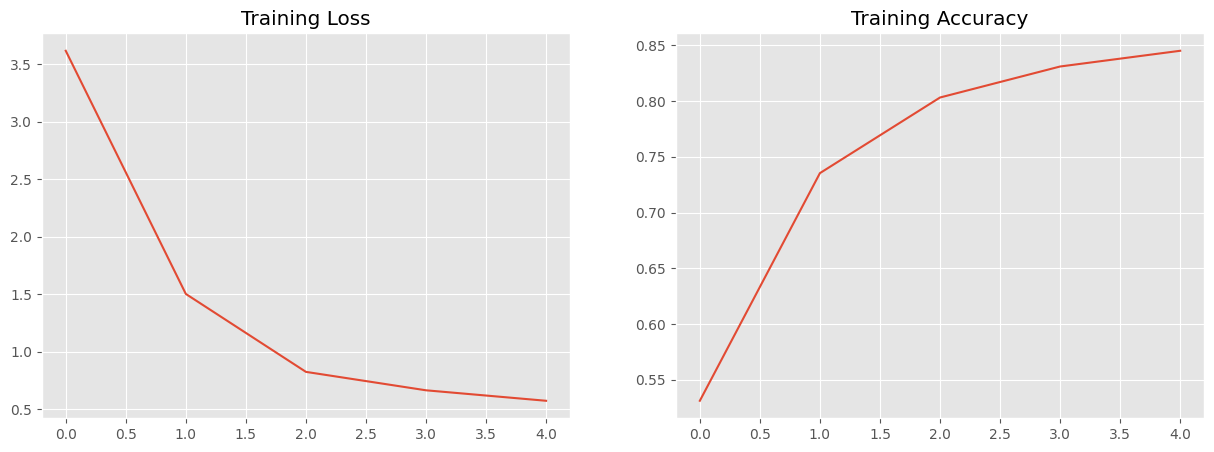

Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.03      0.06       209
           2       0.00      0.00      0.00       244
           3       0.58      0.82      0.68       285
           4       0.00      0.00      0.00       144
           5       0.75      0.87      0.80       464
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        11
          12       0.76      0.88      0.82       485
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17   

In [11]:
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.show()

print("Evaluation:")
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in loader:
        outputs = model(inputs.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

## 9. How This Model Detects Anomalies

This notebook implements **Predictive Anomaly Detection**. Instead of searching for specific "bad" patterns (signatures), the model learns the "normal" patterns of network communication and flags deviations as suspicious.

### 1. The Core Concept: Network Traffic as a Language
The model treats sequences of **Port Numbers** like words in a sentence. 
*   **Normal Behavior:** A typical connection (e.g., Source IP → Destination IP) follows a predictable pattern of port requests.
*   **The Task:** The model is trained to look at the last 10 ports used and **predict the 11th port**.

### 2. Why use a Bidirectional LSTM?
Standard LSTMs only look at the past to predict the future. A **Bidirectional LSTM (Bi-LSTM)** processes the sequence in two directions:
*   **Forward Pass:** Learns what comes *after* a specific port.
*   **Backward Pass:** Learns what usually comes *before* a specific port.
This gives the model a much deeper "contextual understanding" of what a healthy conversation looks like.

### 3. The Detection Logic (The "Surprise" Factor)
Anomaly detection happens by measuring how "surprising" a new network event is to the model:

1.  **Prediction:** For any sequence, the model predicts the probability of every possible next port.
2.  **Comparison:** The actual port that occurs is compared against the prediction.
3.  **Anomaly Scoring:** 
    *   If the model predicted the actual port with **High Probability**, it is marked as **Normal**.
    *   If the model predicted the actual port with **Very Low Probability** (or if the prediction error is high), the event is flagged as an **Anomaly**.

### 4. Examples of High-Confidence Detections
| Threat Type | Behavioral Deviation |
| :--- | :--- |
| **Port Scanning** | A sequence of ports (e.g., 21, 22, 23, 80) that rarely occur together in that order. |
| **DDoS Attack** | Rapid, repetitive requests that break the "rhythm" of standard traffic sequences. |
| **Exfiltration** | Sudden use of non-standard ports after a long sequence of standard port usage. |


## Conclusion
You have successfully built a Deep Learning anomaly detection pipeline! 

### Key Takeaways
1. **Robust Parsing**: Real-world data is messy. Using proper XML parsers like `lxml` with error recovery is crucial.
2. **NLP for Security**: By treating port numbers as tokens, we leveraged powerful RNN architectures (LSTMs) to learn network behaviors.
3. **Bi-LSTMs**: Bidirectional layers allow the model to look at the entire context of a sequence, which often yields better results in pattern recognition than unidirectional LSTMs.